In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from keras import metrics, regularizers
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
import pickle
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


2024-04-29 12:55:49.199575: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 12:55:49.199723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 12:55:49.356957: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:

# Load dataset
data = pd.read_csv("/kaggle/input/pima-indians-diabetes-database/diabetes.csv")


In [4]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
# Data cleaning
cols_with_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
data[cols_with_zeros] = data[cols_with_zeros].replace(0, np.nan)
data[cols_with_zeros] = data[cols_with_zeros].fillna(data[cols_with_zeros].median())


In [7]:
# Split data into features and target variable
X = data.drop("Outcome", axis=1)
y = data["Outcome"]


In [8]:
#Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [9]:
# Function to build ANN model
def create_model():
    model = Sequential()
    model.add(Dense(16, input_dim=X_scaled.shape[1], activation="relu"))
    model.add(Dense(8, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(16, input_dim=X_scaled.shape[1], activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[metrics.AUC()])
    return model


In [10]:
#Define cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [12]:
#Perform cross-validation
conf_matrices = []
accuracies = []
for train_idx, val_idx in cv.split(X_scaled, y):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = create_model()
    history = model.fit(X_train, y_train, epochs=50, batch_size=4, validation_data=(X_val, y_val), verbose=0, callbacks=[early_stopping])

    #Predict probabilities on validation set
    y_pred_proba = model.predict(X_val)
    y_pred = (y_pred_proba > 0.5).astype(int)

    #Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)

    #Calculate confusion matrix
    conf_matrix = confusion_matrix(y_val, y_pred)
    conf_matrices.append(conf_matrix)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


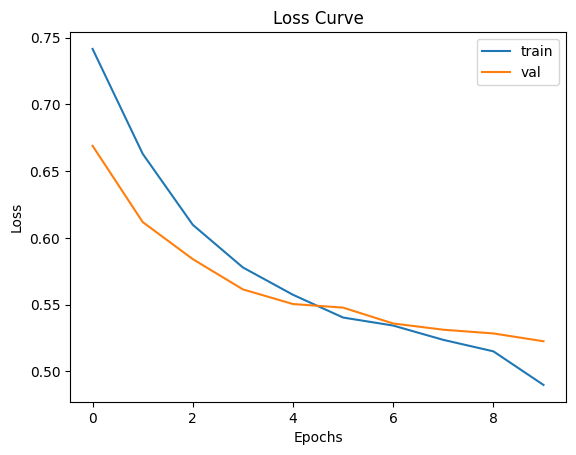

In [13]:
#Plot loss curve for last model
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()


In [14]:
print(history.history.keys())

dict_keys(['auc_4', 'loss', 'val_auc_4', 'val_loss'])


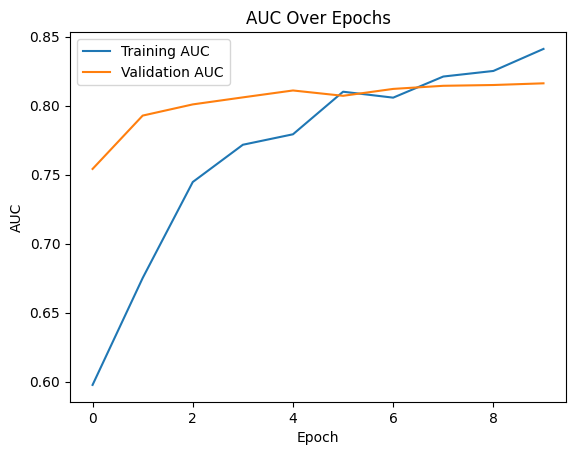

In [15]:
train_auc = history.history['auc_4']
val_auc = history.history['val_auc_4']

# Plot AUC metric for last model
plt.plot(train_auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC Over Epochs')
plt.legend()
plt.show()

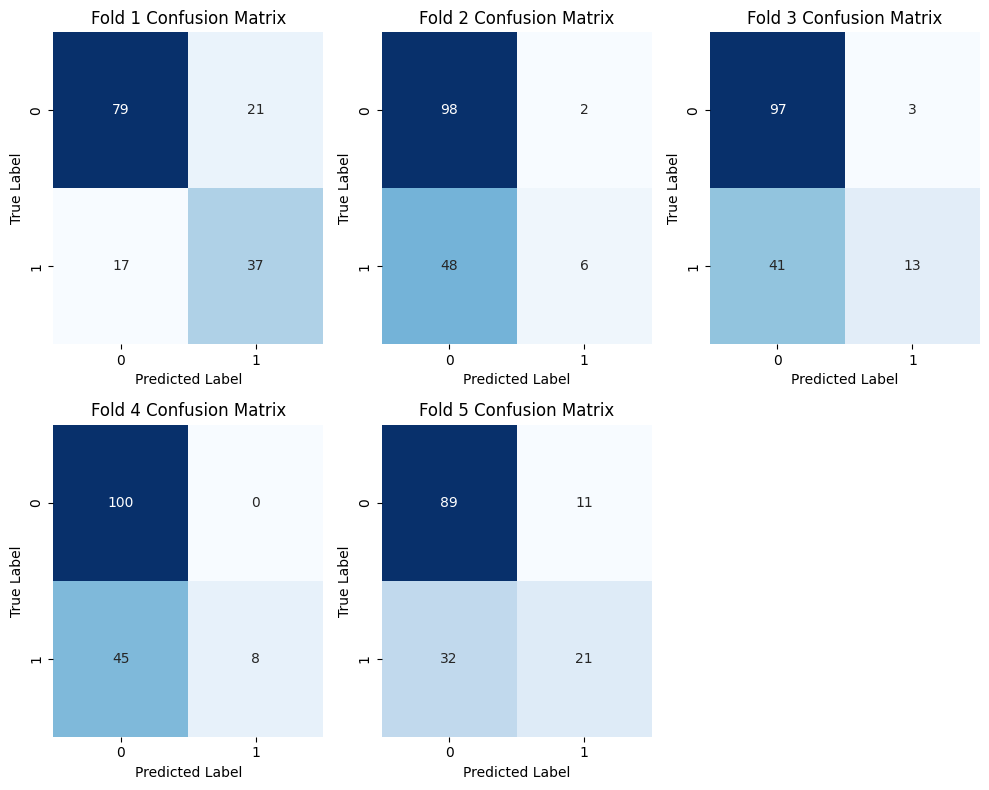

In [16]:
#Plot confusion matrix
plt.figure(figsize=(10, 8))
for i, conf_matrix in enumerate(conf_matrices):
    plt.subplot(2, 3, i + 1)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Fold {i+1} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [17]:
#Print mean accuracy and standard deviation
print("Mean Accuracy For ANN:", np.mean(accuracies))

Mean Accuracy For ANN: 0.7135387488328665


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


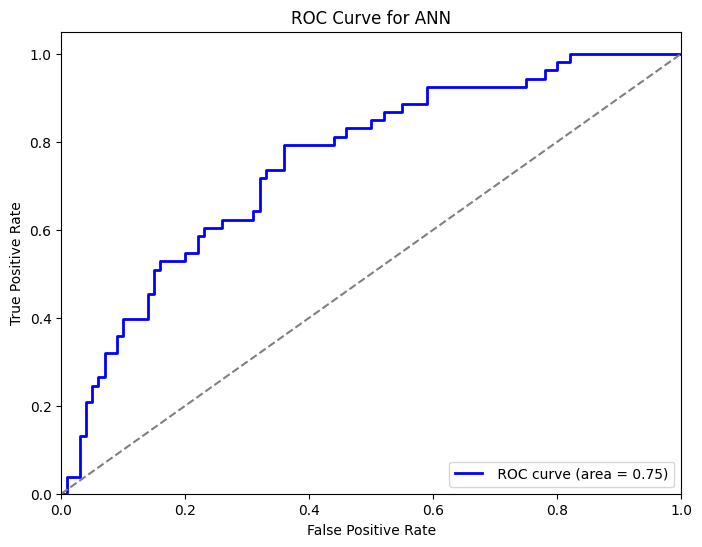

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve for ANN
ann_y_pred_proba = model.predict(X_val)
fpr_ann, tpr_ann, thresholds_ann = roc_curve(y_val, ann_y_pred_proba)
roc_auc_ann = roc_auc_score(y_val, ann_y_pred_proba)

# Plot ROC curve for ANN
plt.figure(figsize=(8, 6))
plt.plot(fpr_ann, tpr_ann, color='blue', lw=2, label=f' ROC curve (area = {roc_auc_ann:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ANN')
plt.legend(loc="lower right")
plt.show()


In [19]:
model.save('ANN_model.keras')

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
# Define hyperparameters grid for Decision Tree
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=cv, scoring='roc_auc')
grid_search.fit(X_scaled, y)

# Get the best model
best_dt_model = grid_search.best_estimator_

with open('DT_Model.pkl', 'wb') as f: # save model
    pickle.dump(best_dt_model, f)


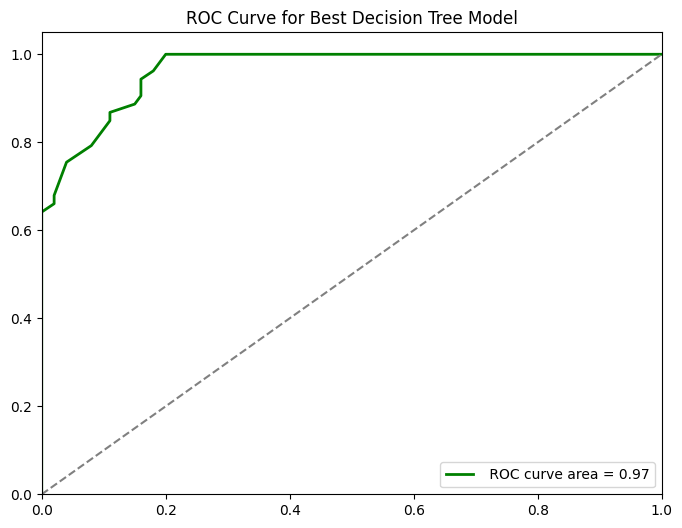

In [22]:
# Plot ROC curve for the best Decision Tree model
best_dt_y_pred_proba = best_dt_model.predict_proba(X_val)[:, 1]
fpr_best_dt, tpr_best_dt, thresholds_best_dt = roc_curve(y_val, best_dt_y_pred_proba)
roc_auc_best_dt = roc_auc_score(y_val, best_dt_y_pred_proba)

# Plot ROC curve for the best Decision Tree model
plt.figure(figsize=(8, 6))
plt.plot(fpr_best_dt, tpr_best_dt, color='green', lw=2, label=f' ROC curve area = {roc_auc_best_dt:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.title('ROC Curve for Best Decision Tree Model')
plt.legend(loc="lower right")
plt.show()


In [23]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
import pickle

In [ ]:
ann_model = load_model('ANN_model.keras')
with open('DT_Model.pkl', 'rb') as f:
    dt_model = pickle.load(f)

In [24]:
# Load pre-trained models
ann_model = load_model('ANN_model.keras')
with open('DT_Model.pkl', 'rb') as f:
    dt_model = pickle.load(f)

In [25]:
# Function to make predictions
def make_predictions(input_data):
    ann_prediction = ann_model.predict(input_data)[0][0]
    dt_prediction = dt_model.predict(input_data)[0]
    return dt_prediction, ann_prediction

In [26]:
# Define input widgets
pregnancies_input = widgets.IntText(description='Pregnancies:', value=0)
glucose_input = widgets.IntText(description='Glucose:', value=0)
blood_pressure_input = widgets.IntText(description='Blood Pressure:', value=0)
skin_thickness_input = widgets.IntText(description='Skin Thickness:', value=0)
insulin_input = widgets.IntText(description='Insulin:', value=0)
bmi_input = widgets.FloatText(description='BMI:', value=0.0)
diabetes_pedigree_input = widgets.FloatText(description='Diabetes Pedigree:', value=0.0)
age_input = widgets.IntText(description='Age:', value=0)

In [27]:
# Define prediction button
predict_button = widgets.Button(description='Predict')

In [28]:
# Output widget for displaying predictions
output = widgets.Output()


In [29]:
# Define function to handle button click event
def on_predict_button_clicked(b):
    input_data = np.array([[pregnancies_input.value, glucose_input.value, blood_pressure_input.value,
                            skin_thickness_input.value, insulin_input.value, bmi_input.value,
                            diabetes_pedigree_input.value, age_input.value]])
    input_data_scaled = scaler.transform(input_data)
    dt_prediction, ann_prediction = make_predictions(input_data_scaled)
    
    with output:
        output.clear_output()
        print("Decision Tree Prediction:", dt_prediction)
        print("ANN Prediction:", ann_prediction)



In [30]:
# Attach button click event to the button
predict_button.on_click(on_predict_button_clicked)

In [31]:
# Display the widgets
display(pregnancies_input, glucose_input, blood_pressure_input,
        skin_thickness_input, insulin_input, bmi_input,
        diabetes_pedigree_input, age_input, predict_button, output)


IntText(value=0, description='Pregnancies:')

IntText(value=0, description='Glucose:')

IntText(value=0, description='Blood Pressure:')

IntText(value=0, description='Skin Thickness:')

IntText(value=0, description='Insulin:')

FloatText(value=0.0, description='BMI:')

FloatText(value=0.0, description='Diabetes Pedigree:')

IntText(value=0, description='Age:')

Button(description='Predict', style=ButtonStyle())

Output()

In [34]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
